In [16]:
import numpy as np
import tempfile
import os
import matplotlib.pyplot as plt
import scipy.io as sci
import scipy.fftpack as sff

**I - Data generation and manipulation**

The objective of this first short part is to create some datasets to get accustomed to them. It will enable us to :
- recall the notion of sparsity ;
- geometrically understand the effect of the mixing.

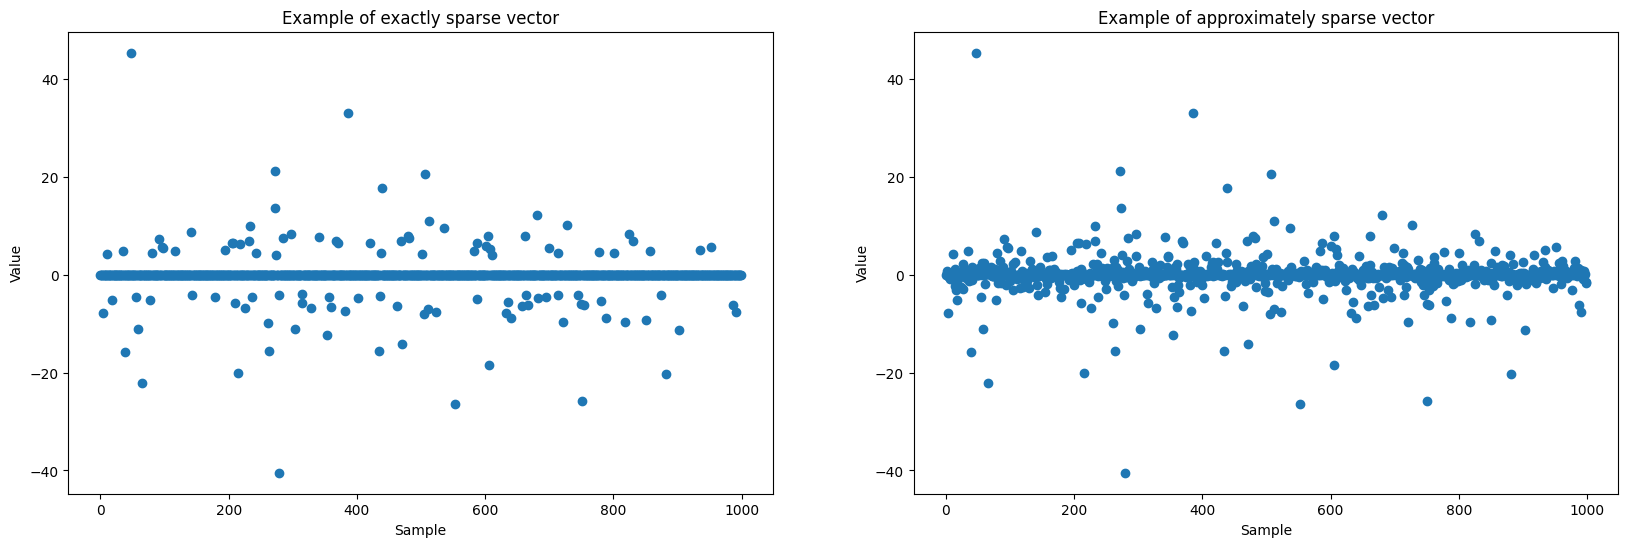

In [17]:
power = 3
approx_sparse = np.random.randn(1000)**power
exact_sparse = approx_sparse*(np.abs(approx_sparse)>4)

fig = plt.figure(figsize=(20, 6))
fig.add_subplot(1,2,1)
plt.plot(exact_sparse, 'o')
plt.xlabel('Sample')
plt.ylabel('Value')
plt.title('Example of exactly sparse vector');

fig.add_subplot(1,2,2)
plt.plot(approx_sparse, 'o')
plt.xlabel('Sample')
plt.ylabel('Value')
plt.title('Example of approximately sparse vector');

What is the difference between an exactly and an approximately sparse signal? Recall the two corresponding definitions.

**Answer:**

An exactly sparse signal contains a significant number of coefficients that are exactly zero, meaning the signal has only a few non-zero elements. In contrast, an approximately sparse signal contains many non-zero coefficients, but most of these have small magnitudes and contribute little to the overall signal, allowing the signal to be closely approximated by a sparse representation. Essentially, exact sparsity deals with true zeros, while approximate sparsity deals with near-zeros that are small enough to often be negligible.

Now let's start to look at some mixtures and to try to geometrically interpret the impact of the mixing.

First, generate a simulated source S matrix. Plot the corresponding scatter plot. Interpret the shape of the scatter plot you obtain.

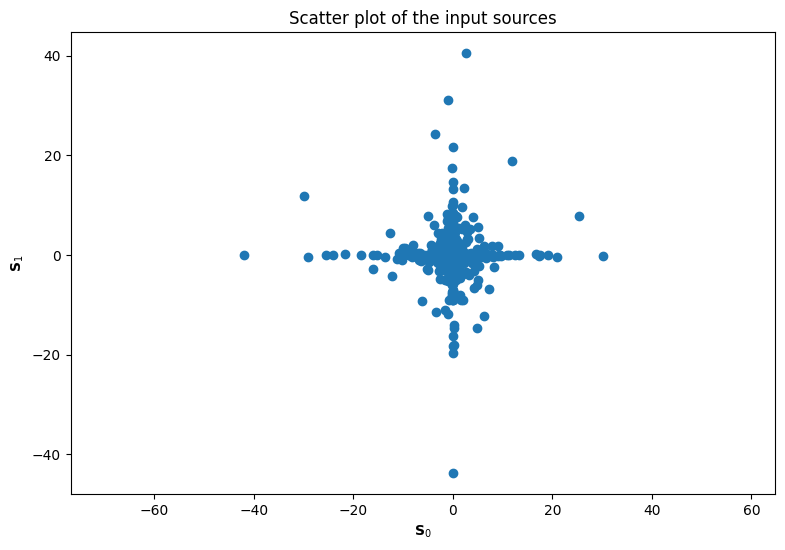

In [18]:
n = 2         # number of sources
t = 1024      # number of samples
noise_level = 200 # noise level, in dB
power = 3 # power exponent used in the source generation



# TO DO : generate a simulated source S matrix.
# S will be of dimensions n x t.
# Each of the n sources (i.e. lines of S) will follow the approximately sparse
# law we used above.
S = np.zeros((n,t)) # TO CHANGE
S[0, :] = np.random.randn(t)**power
S[1, :] = np.random.randn(t)**power

fig = plt.figure(figsize=(20, 6))
fig.add_subplot(1,2,1)
plt.title('Scatter plot of the input sources')
plt.plot(S[0, :], S[1, :], 'C0o')
plt.xlabel("$\mathbf{S}_0$")
plt.ylabel("$\mathbf{S}_1$")
plt.axis('equal');

In [19]:
# Here, we generate a mixture matrix (dimensions m x t) from the sources in S
m = 4         # number of observations

A = np.random.randn(m,n)
X = A@S

noise_level = 120

# To be more realistic, we add some noise to the mixing.
# Mixtures with SNR > 120 dB can be considered as noiseless for most applications.
if noise_level < 120:
    #--- Add noise
    N = np.random.randn(m,t)
    N = 10.**(-noise_level/20.)*np.linalg.norm(X)/np.linalg.norm(N)*N
    X = X + N

Plot the scatter plot of X. What do you see ?

What do the directions of the lines you observe correspond ?

Try several A matrices, noise_values and powers. Any comment?

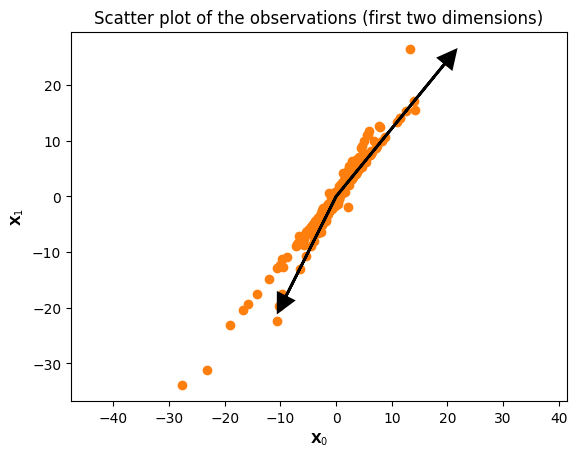

In [20]:
plt.title('Scatter plot of the observations (first two dimensions)')
vrange = 0.25*max(np.sqrt(np.sum(X*X, 0)))
plt.arrow( 0, 0, vrange*A[0, 0], vrange*A[1, 0], fc="k", ec="k", linewidth=2, head_width=0.1*vrange, head_length=0.1*vrange)
plt.arrow( 0, 0, vrange*A[0, 1], vrange*A[1, 1], fc="k", ec="k", linewidth=2, head_width=0.1*vrange, head_length=0.1*vrange)
plt.plot(X[0,:], X[1,:], 'C1o', zorder=0)
plt.xlabel("$\mathbf{X}_0$")
plt.ylabel("$\mathbf{X}_1$")
plt.axis('equal');

**Answer:**

The scatter plot reveals a distribution predominantly along two distinct lines, indicating two main directional components in the data, represented by the arrows. These arrows show the influence and direction of each source component mixed into the observed signals via the mixing matrix $A$. Variations in $A$ can change these observed directions, thus altering how the sources combine in the observed space. Higher noise levels may blur these distinct lines, affecting the visibility and distinction of source directions, which is crucial for evaluating the robustness of source separation methods. Additionally, altering the power used to generate the sources can affect their sparsity or peakiness, potentially enhancing the projection effects of the sources, particularly if they are non-Gaussian.

**II - Performing non-blind source separation**

**1) Data generation**

Before going into blind source separation, in which we want to find physical **A** and **S** matrices such that **X = AS + N**, let us first consider the simpler setting in which we know **A** and want to recover **S**.
We will consider the noisy mixture of two sine signals. The methodology extends to more complex datasets.

N.B. : unmixing two sinus signal could be done much more easily than using the algorithms we saw during the class. Nevertheless, focusing on such synthetic data enables an easy visualization. The principle readily extend to more complex datasets, such as images.

(-25.0, 25.0)

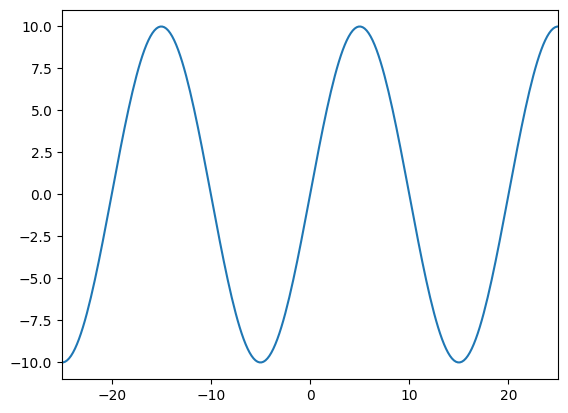

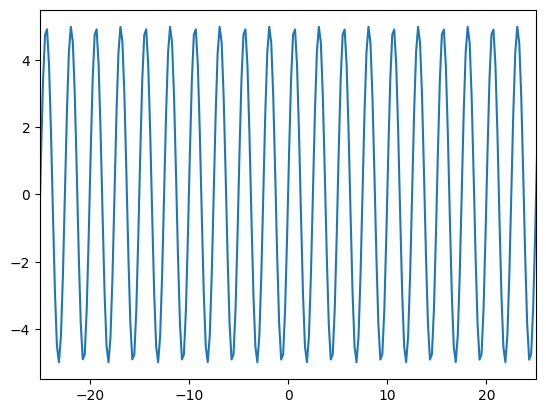

In [21]:
# Source generation
t = 10000
x_abs = np.linspace(-1000,1000,t)

S = np.zeros((2,t))
S[0,:] = 10*np.sin(2*np.pi*0.05*x_abs)
S[1,:] = 5*np.sin(2*np.pi*0.4*x_abs)

plt.figure(),plt.plot(x_abs,S[0,:])
plt.xlim([-25,25])
plt.figure(),plt.plot(x_abs,S[1,:])
plt.xlim([-25,25])

Here, we will transform the sources signals S into the DCT domain.

What is the objective of using the DCT?

Plot the above DCT and justify what you see. Pay attention to the labeling of the x-axis. Try with sines of various frequencies.

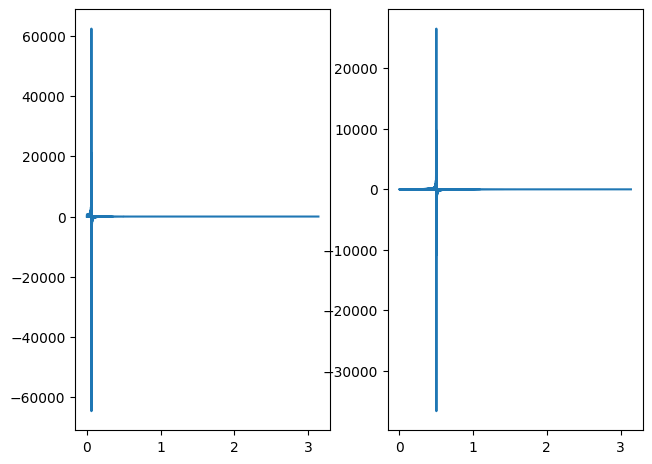

In [29]:
# Transformation into the DCT domain
Sf = sff.dct(S)

k = np.linspace(0, t-1, t)
x = np.pi/t * k

fig, ax =  plt.subplots(1,2)
fig.tight_layout()
ax[0].plot(x, Sf[0, :])
ax[1].plot(x, Sf[1, :])
fig.show()


Data generation : now, we will create a mixture X = AS + N.

Plot the mixtures. Explain what you see.

Compute the DCT of X. Plot it and explain. Which caracteristic of the DCT will we use to recover the sources?

**Answer:**

The application of the Discrete Cosine Transform (DCT) to a mixture of two sine signals, denoted by $X$, transforms the signal from the time domain to the frequency domain, where it often exhibits a sparse representation. This sparsity is characterized by distinct spikes, each representing the frequencies of the original source signals. By transforming $X$ using DCT, the mixed signals' dominant frequencies become isolated and more identifiable, facilitating the potential reconstruction of the original source signals, albeit with a possible multiplicative scaling. This approach is particularly useful in signal processing for effectively separating or identifying source components within complex mixtures, leveraging the clarity and simplicity provided by the frequency domain sparsity.

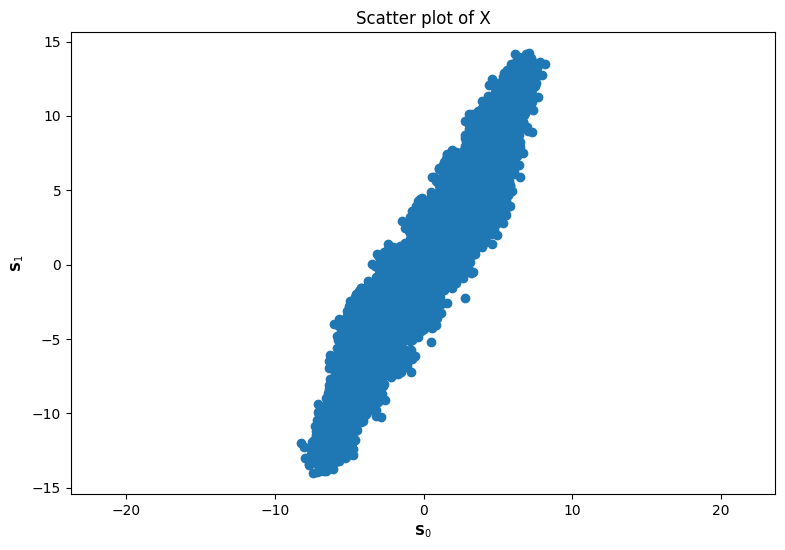

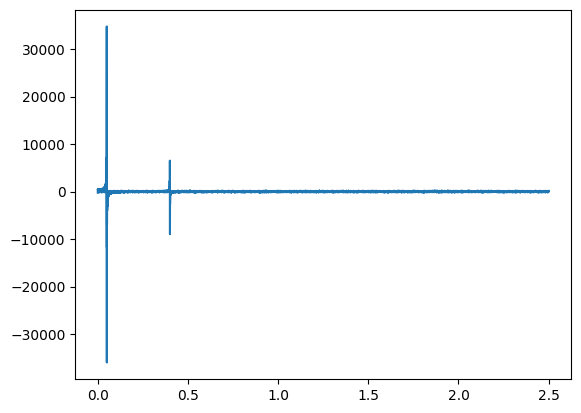

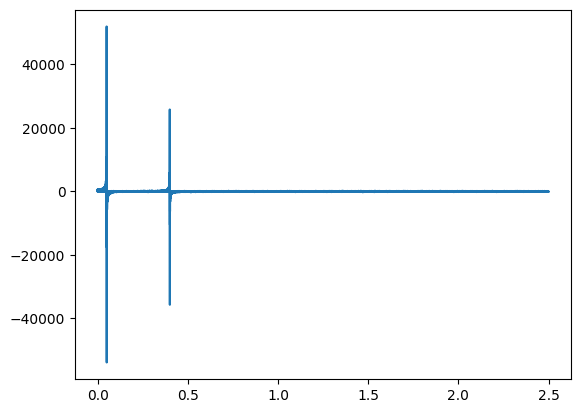

In [23]:
A = np.array([[0.5547002 , 0.24253563],
       [0.83205029, 0.9701425 ]]) # You can try other A values, but the columns must have a unitary norm.

X = A@S
X = X + 0.5*np.random.randn(np.shape(X)[0],np.shape(X)[1])# You can try other noise values

fig = plt.figure(figsize=(20, 6))
fig.add_subplot(1,2,1)
plt.title('Scatter plot of X')
plt.plot(X[0, :], X[1, :], 'C0o')
plt.xlabel("$\mathbf{S}_0$")
plt.ylabel("$\mathbf{S}_1$")
plt.axis('equal');


Xf = sff.dct(X)

plt.figure()
plt.plot(np.linspace(0,t/4000,t), Xf[0,:])

plt.figure()
plt.plot(np.linspace(0,t/4000,t), Xf[1,:])

**2) Source separation**

Now that we generated observations from simulated sources, we will focus on the source separation problem: recovering the sources from the observations (and the knowledge of A, since we are here in the non-blind setting).

To do that, we propose here to solve the source separation problem using a sparsity constraint on the sources. The cost function will then be minimized using the ISTA algorithm.

First, write the cost function we want to minimize to perform non-blind sparse source separation. Explain each term (in particular, which one is smooth or not). Is this cost function convex?


**Answer:**

We aim to minimize the objective function $ ||X - AS||^2 + \lambda ||S||_1 $ with respect to $ S $. The function comprises two terms: the first, $ ||X - AS||^2 $, is the data-fidelity term, which measures how closely the model fits the original data. The second term, $ \lambda ||S||_1 $, encourages sparsity in the solution by penalizing it based on the sum of the absolute values of its components—this is the L1 norm. Although this function is convex, making it suitable for optimization, it is non-differentiable due to the presence of the L1 norm.

Compute the gradient along the S variable of the data-fidelity term.

**Answer:**

The gradient of the term $ ||X - AS||^2 $ with respect to $ S $ is given by $ \nabla_S ( ||X - AS||^2) = -A^T(X-AS) $. This expression represents the derivative of the squared error term, which quantifies the discrepancy between the observed data $ X $ and the model predictions $ AS $. The negative sign indicates the direction of steepest descent, guiding the adjustments needed to reduce the error and improve the model fit.

Recall what the proximal operator of the l1-norm is.

**Answer:**

The formula of the proximal operator for the L1 norm, often used in optimization problems involving sparsity regularization, is defined as:

$$
\text{prox}_{\lambda\|.\|_1}(S)_i = \left\{
\begin{array}{lll}
    s_i - \lambda & \text{if } s_i > \lambda \\
    0 & \text{if } |s_i| \le \lambda \\
    s_i + \lambda & \text{if } s_i < -\lambda \\
\end{array}
\right.
$$

This operator effectively shrinks the components of the vector $ S $ towards zero by $ \lambda $ and sets elements of $ S $ to zero if their absolute value is less than or equal to $ \lambda $. It's particularly useful for enforcing sparsity in solutions to optimization problems by penalizing the L1 norm of the variable $ S $. This method is central to techniques like Lasso in statistical modeling and sparse coding in machine learning, where it helps in reducing overfitting by limiting the number of non-zero coefficients in the model.

In [24]:
# TO DO: implement the proximal operator of the l1-norm in the above function:
def prox_l1(S_est,thrd):
  # To complete
  S_est[S_est>thrd] -=  thrd
  S_est[S_est<-thrd] += thrd
  S_est[abs(S_est)<=thrd] = 0

  return S_est



Explain the main idea of the ISTA algorithm. Then, implement it.

**Answer:**

The Iterative Shrinkage-Thresholding Algorithm (ISTA) is a method used to solve optimization problems that include an L1 norm regularization term to promote sparsity. The approach combines two main steps iteratively: first, a gradient descent step on the differentiable part of the objective function to reduce the least squares error $ \|X - AS\|^2 $, followed by a soft thresholding operation that acts as a proximal operator of the L1 norm. This thresholding reduces the magnitude of each element of the solution vector $ S $ and sets smaller elements to zero based on the regularization parameter $ \lambda $. ISTA alternates between these two steps until the solution stabilizes, effectively finding sparse solutions efficiently in fields like compressed sensing and sparse coding.

In [30]:
# TO DO: implement the ISTA algorithm to minimize the cost function you wrote in question II-2-1.
def ISTA(X,A = np.eye(2),n=2,lamb=0,nbIt = 100):
  k=0
  gamma = 0.9/ np.linalg.norm(A.T@A)

  S_est = np.zeros((n, X.shape[1]))

  while k < nbIt :
      S_est = prox_l1(S_est + gamma * A.T @ (X-A@S_est), gamma*lamb)

      k += 1

  return S_est

It's now time to play with the code : launch the ISTA algorithm and look at the results.

Try various lamb values. What is the minimum value you should no go below? What is the issue with choosing too big values?

In [31]:
S_estf = ISTA(Xf,A = A,n=2,lamb=1000,nbIt = 1000)

**Answer:**

If $ \lambda $ is set too high, the regularization term dominates, leading to a solution that is excessively sparse, with most of its elements being zero. Conversely, if $ \lambda $ is set too low, the regularization effect is insufficient, resulting in a noisy solution that obscures the identification of the source signals' frequencies.

Plot the estimated sources in the DCT domain. What kind of sparsity to they exhibit? Why?

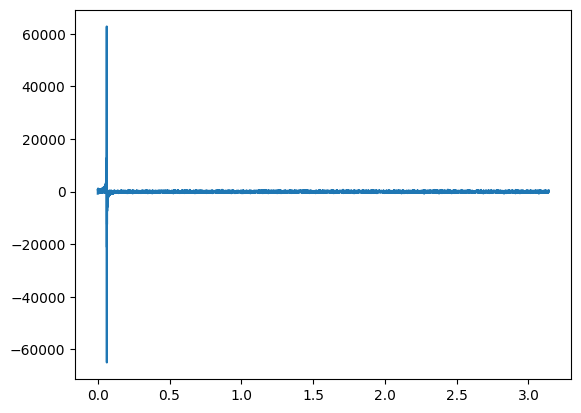

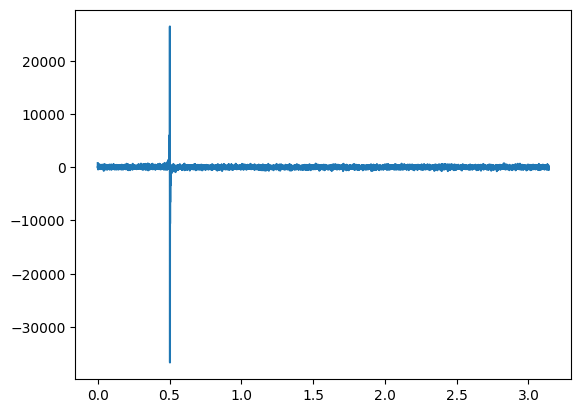

In [32]:
plt.plot(x,S_estf[0,:])
plt.show()
plt.plot(x,S_estf[1,:])
plt.show()

Transform the sources back in the direct domain. Plot them. What do you see? Explain the differences with the original sources. Conclude.

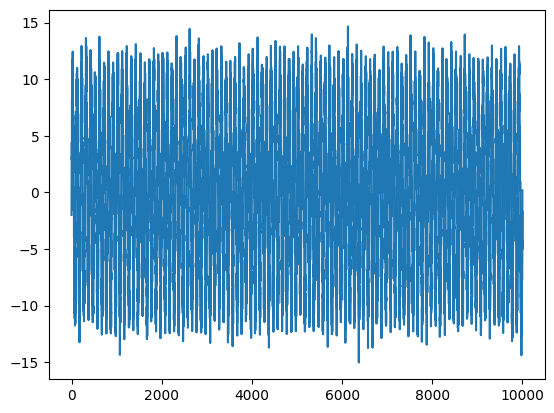

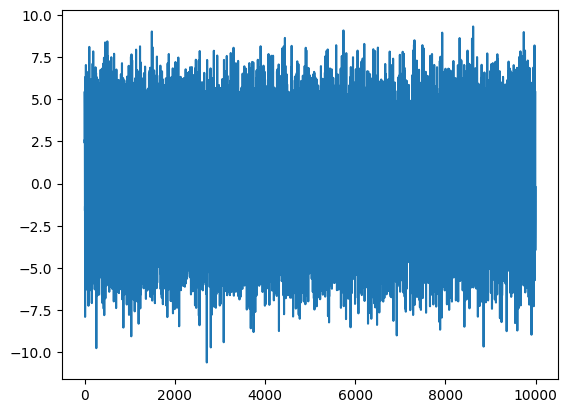

In [33]:
S_ori = sff.idct(S_estf)/20000


plt.plot(S_ori[0,:])
plt.show()
plt.plot(S_ori[1,:])
plt.show()

**Answer:**

The reconstructed signals are finite and do not accurately represent the original signals at the boundaries of the domain. However, aside from these edge effects, they maintain the same amplitude and frequencies as the original signals.

**III - Blind Source Separation : PALM**

Let's now delve into the core problem : *blind* source separation, in which **A** is unknown. To leverage sparsity, we will use the PALM algorithm.

Thoughout this whole section, we will re-use the same synthetic data as above (i.e., the one generated in II-1).

Write the cost function we want to minimize to perform *blind* sparse source separation. Explain each term (in particular, which one is smooth or not). Is this cost function convex?




**Answer:**

To address the problem of blind sparse source separation in hyperspectral unmixing (HSU), we focus on minimizing a specific cost function that incorporates data fidelity, sparsity, and constraints on the mixing matrix. Here’s the cost function based on the content from the provided course slides:

### Cost Function:
$$ f(A, S) = \frac{1}{2} \|X - AS\|^2_F + \lambda \|S\|_1 + \iota_{\|\cdot\|_2 \leq 1}(A) $$

### Explanation of Each Term:
1. **Data-Fidelity Term $\frac{1}{2} \|X - AS\|^2_F$**:
   - This term measures the fit between the observed data $X$ and the data reconstructed by the product of the mixing matrix $A$ and the source matrix $S$. It is smooth since it involves squared Frobenius norm, which is continuously differentiable with respect to $A$ and $S$.

2. **Sparsity Term $\lambda \|S\|_1$**:
   - The L1 norm regularization promotes sparsity in the source matrix $S$. It encourages many elements of $S$ to be zero, helping in recovering the sparsest solution that explains the data. This term is non-smooth due to the absolute value operation in the L1 norm.

3. **Oblique Constraint $\iota_{\|\cdot\|_2 \leq 1}(A)$**:
   - This is an indicator function that enforces a constraint on the columns of $A$ to have a unit norm. This constraint prevents the scale indeterminacy problem in the solution and helps in stabilizing the optimization process. It is non-smooth and non-convex.

### Convexity of the Cost Function:
The cost function is not convex as a whole due to the coupling of $A$ and $S$ in the bilinear term $AS$ and the non-smooth, non-convex constraint on $A$. While each term is convex with respect to one variable if the other is fixed, the overall function does not satisfy global convexity because of the bilinear interaction between $A$ and $S$ and the additional constraints imposed.

This non-convexity implies that finding a global minimum is challenging, and the optimization might only guarantee convergence to a local minimum or a saddle point. However, the structure of the problem allows for using specialized algorithms like PALM (Proximal Alternating Linearized Minimization), which effectively handles the alternating optimization of $A$ and $S$ by exploiting the convexity in one variable while fixing the other. This approach is well-suited for problems like HSU where sparsity and physical constraints (like non-negativity or unit norm) play a crucial role in the source separation process.

Recall what the gradient of the data fidelity term over A is.

Compte the proximal operator of the oblique constraint. Implement it.

**Answer:**

The proximal operator for the oblique constraint, which requires each column of matrix $A$ to have unit $\ell_2$-norm, can be implemented as a normalization step for each column. This operator projects each column of $A$ onto the unit sphere in $\ell_2$-norm space. The formulation provided in the course slides under the sparse blind source separation (SBSS) framework is an essential component to ensure that the columns of $A$ do not grow unbounded, which could lead to numerical instability and meaningless solutions.

### Proximal Operator of the Oblique Constraint:
For a matrix $A$ with columns $a_i$, the proximal operator is applied column-wise as follows:
$$
\text{prox}_{\iota_{\|\cdot\|_2 \leq 1}}(A) = \left[\frac{a_1}{\|a_1\|_2}, \frac{a_2}{\|a_2\|_2}, \dots, \frac{a_n}{\|a_n\|_2}\right]
$$
This operation normalizes each column vector $a_i$ to have a norm of 1.


In [34]:
def prox_oblique(A):
#    # TO DO
  A = A / (1e-6+np.sqrt(np.sum(A**2, axis=0)))
  return A

Implement the PALM algorithm to minimize the cost function you wrote in III-1).

In [35]:
def PALM(X,n=2,lamb=0,nbIt = 100):
#
#    # TO DO
  A_est = np.random.rand(X.shape[0], n) #/ (1e-6+np.sum(A_est@A_est.T, axis=0))
  #A_est = A
  S_est = np.zeros((n, X.shape[1]))  #(np.random.rand(n, X.shape[1])>0.7)
  for i in range(nbIt):
  #  print(i, np.max(S_est))
    S_est = prox_l1(S_est + (0.9/(1e-6 + np.sum(A_est.T @ A_est))) * (A_est.T @ (X-(A_est@S_est))), lamb)
    A_est = prox_oblique(A_est + 0.9/(1e-6+np.sum(S_est@S_est.T))* (X-A_est @ S_est) @ S_est.T)

  return A_est,S_est


Launch the PALM algorithm to retrieve both A and S from X. Plot your results. How good is the separation? The separation quality is usually well evaluated comparing the true and estimated A matrices.

In [36]:
A_est, S_estf = PALM(Xf,n=2,lamb=1000,nbIt = 1000)

In [37]:
print(A)
print(A_est)
print(np.max(S_estf))

[[0.5547002  0.24253563]
 [0.83205029 0.9701425 ]]
[[0.12794571 0.77949365]
 [0.99178016 0.62640853]]
40154.65481364981


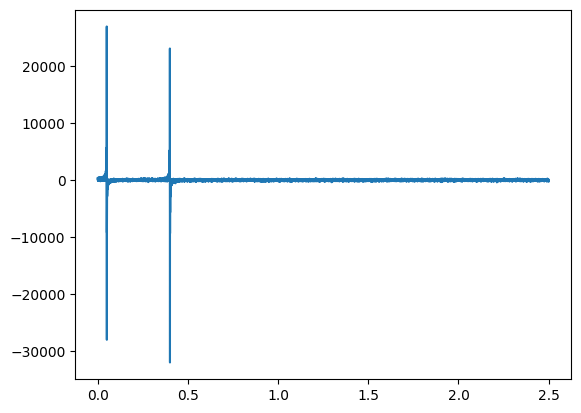

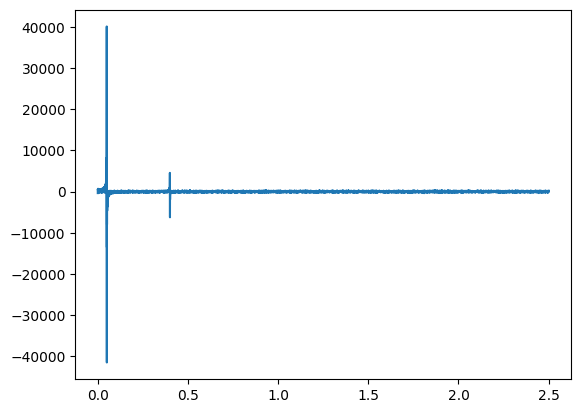

In [38]:
plt.figure()
plt.plot(np.linspace(0,t/4000,t), S_estf[0,:])

plt.figure()
plt.plot(np.linspace(0,t/4000,t), S_estf[1,:])

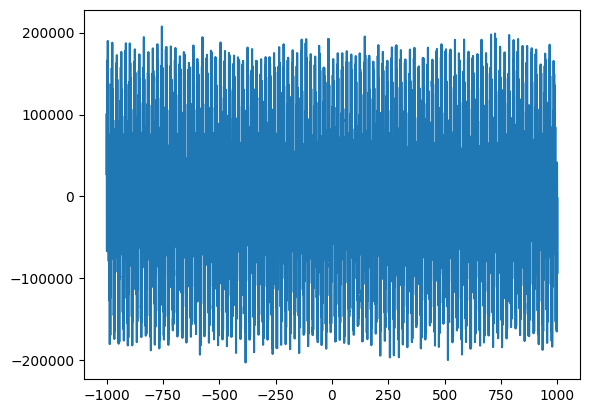

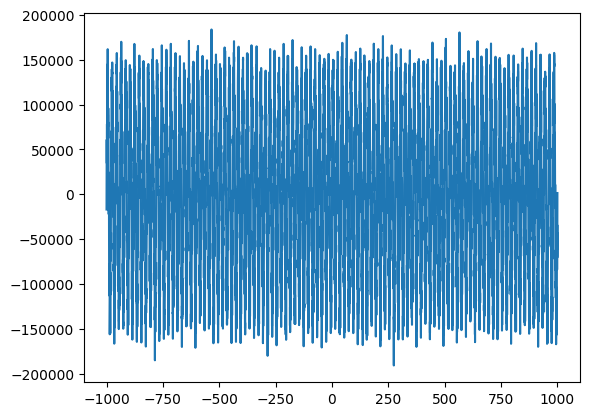

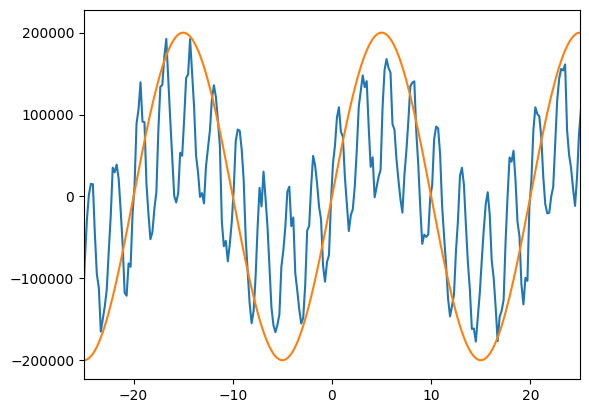

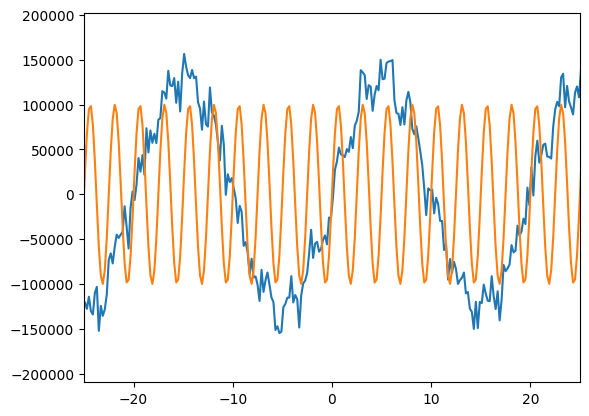

In [39]:
S_est1 = sff.idct(S_estf)
plt.figure(),plt.plot(x_abs,S_est1[0,:])
# plt.xlim([-25,25])
plt.figure(),plt.plot(x_abs,S_est1[1,:])
# plt.xlim([-25,25])

plt.figure()
plt.plot(x_abs,S_est1[0,:])
plt.plot(x_abs,S[0,:]*2*t)
plt.xlim([-25,25])
plt.show()
plt.figure(),
plt.plot(x_abs,S_est1[1,:])
plt.plot(x_abs,S[1,:]*2*t)
plt.xlim([-25,25])
plt.show()